# Analysis of SAP Careers Database

*Data timestamp: Mar 13, 2019*

This notebook analyzes job data from the SAP careers website https://jobs.sap.com/. We first determine the most important requirements for a particular job and then build a model to predict a job title given a list of job requirements.

## Contents:
**[1. Analysis of the most common uni- and bi-grams among job requirements](#ngrams)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[1.1 Analysis by frequency](#freq)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[1.2 Analysis by pointwise mutual information (PMI) and hypothesis testing](#PMI)**

**[2. Building a job title predictor](#predictor)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[2.1 Obtaining more data](#moredata)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[2.2 Converting words to vectors](#vectorize)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[2.3 Classification](#classify)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[2.4 Visualization](#visualize)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**[2.5 Prediction](#predict)**

**[3. Conclusion](#conclusion)**

<a id='ngrams'></a>
## 1. Analysis of the most common uni- and bi-grams among job requirements

<a id='freq'></a>
### 1.1 Analysis by frequency

Let's find out what the most important job requirements for a data scientist at SAP are.

In [1]:
# Load data science modules
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Load SAP web scraper
from get_jobs import get_jobs

We fetch all current job openings containing "data scientist" in their title.

In [2]:
# Get data
ds_data = get_jobs('data scientist')

Fetching results...
Done.
Found 12 results.


In [3]:
# Create DataFrame using first row as headers
ds = pd.DataFrame(ds_data[1:], columns = ds_data[0]) # uncomment if loading from web scraper
#ds = pd.read_csv('data scientist.csv') # uncomment if loading from csv

# Convert data types
ds['Requisition ID'] = ds['Requisition ID'].apply(pd.to_numeric)
ds['Date Posted'] = ds['Date Posted'].apply(pd.to_datetime)

# Index by 'Requisition ID' and sort by 'Date Posted'
ds.set_index('Requisition ID', inplace = True)
ds.sort_values(by = ['Date Posted'], inplace = True, ascending = False)

# Save data to pickle for future reproducibility
#import sys
#sys.setrecursionlimit(10000)
#ds.to_pickle("./ds.pkl")

ds.head()

,Job Title,Date Posted,Location,Expected Travel,Career Status,Employment Type,Requirements
Requisition ID,,,,,,,
202628,"Intern, Innovation Center - Engineers and Data...",2019-03-12,"Irvine, CA, US",0 - 10%,Student,Intern,Major in Software/Computer Engineering/Data Sc...
202289,SAP IBS iXp Intern - Data Scientist Job,2019-03-08,"Palo Alto, CA, US",0 - 10%,Student,Intern,SAP’s Internship Experience Project is SAP’s g...
203244,SAP Concur iXp intern- Customer Experience Tra...,2019-03-06,"Bellevue, WA, US",0 - 10%,Student,Intern,We’re looking for someone who can challenge th...
210440,Senior Data Scientist - SAP Business Network Job,2019-03-06,"Bellevue, WA, US",0 - 10%,Professional,Regular Full Time,The SAP Business Network Team is looking for a...
210651,Working Student: Data Scientist (Data Engineer...,2019-03-04,"Walldorf/St. Leon-Rot, BW, DE",0 - 10%,Student,Limited Part Time,Student (f/m) at a university or university of...


Proceed to count the most common uni- and bigrams by frequency.

In [4]:
# Import NLP and other required modules
import re, collections, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

In [5]:
# Concatenate the requirements column
ds_req = ds['Requirements'].str.cat(sep = '\n')
ds_req[:1000]

'Major in Software/Computer Engineering/Data Science or related fields\nExtraordinary programming skills (e.g. C#, C++, Objective C, JavaScript, Java and/or HTML5) and/or\nExperience with machine learning & artificial intelligence (computer vision, NLP, data science, etc.).\nEnjoying ambiguous challenges, fast iterations and independent thinking\nHaving worked with various technologies during your studies but also independent of it (e.g. as an intern, as trainee, at a start-up or together with friends or just for fun), to demonstrate that you’re driven to create beautiful & valuable technology solutions.\nSAP’s Internship Experience Project is SAP’s global, paid internship program that provides university students with the opportunities to find purpose in their careers.\nWe’re looking for someone who can challenge the status quo and likes to stay curious. You enjoy working on meaningful projects and are energized by lifelong learning.\nEnrolled in a degree program in Mathematics, Physi

In [6]:
# Function checking if a token is a stop word or number
stop = set(stopwords.words('english'))
def is_ok(token):
    return re.match(r'^[a-z]+.*$', token) and token not in stop

# Function using NLTK's 'tokenize' in conjunction with our word filter
def tokenize(sent):
    return [word for word in word_tokenize(sent.lower()) if is_ok(word)]

In [7]:
# Tokenize the requirements text block after replacing forward slash by 'or'
ds_tokenized = tokenize(re.sub(r'/', ' or ', ds_req))

In [8]:
# Count and display most common unigrams
ds_unigrams_freq = collections.Counter(ds_tokenized)
ds_unigrams_freq_table = pd.DataFrame.from_dict(ds_unigrams_freq, orient = 'index', \
                columns = ['Frequency']).sort_values(by = ['Frequency'], ascending = False)
ds_unigrams_freq_table.head(21)

,Frequency
experience,33
data,25
science,16
knowledge,15
learning,15
working,14
sap,12
skills,11
strong,10
business,10


From this we see that, among the technical skills required, **Python**, **R,** and **SQL**—in this order—are the most common. The ideal candidate should also have a **degree** in **statistics** or **mathematics**.

In [9]:
ds_bigrams = ngrams(ds_tokenized, 2)
ds_bigrams_freq = collections.Counter(ds_bigrams)
ds_bigrams_freq_table = pd.DataFrame.from_dict(ds_bigrams_freq, orient = 'index', \
                columns = ['Frequency']).sort_values(by = ['Frequency'], ascending = False)

Before proceeding, let us filter for bigrams only of the form (Noun, Noun) or (Adjective, Noun).

In [10]:
# Function to filter for bigrams of the form (Noun, Noun) or (Adjective, Noun)
def rightTypes(ngram):
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [11]:
ds_bigrams_filtered = ds_bigrams_freq_table[ds_bigrams_freq_table.index.map(lambda x: \
                                                                            rightTypes(x))]
ds_freq_top = ds_bigrams_filtered.head(20).index.values
ds_bigrams_filtered.head(20)

,Frequency
"(data, science)",10
"(machine, learning)",8
"(computer, science)",6
"(someone, challenge)",4
"(meaningful, projects)",4
"(curious, enjoy)",4
"(quo, likes)",4
"(status, quo)",4
"(challenge, status)",4
"(degree, program)",4


From this, we further deduce that the ideal candidate possesses knowledge of **machine learning**, has strong **communication skills**, a **master's degree** in **computer science**, and **work experience**.

To glean further information, we employ some metrics other than frequency.

<a id='PMI'></a>
### 1.2 Analysis by pointwise mutual information (PMI) and hypothesis testing

We define three metrics and display and discuss the results at the end.

### a. PMI

The *pointwise mutual information (PMI) score* measures how much more likely the words co-occur than if they were independent.

In [12]:
bigrams = nltk.collocations.BigramAssocMeasures()
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(ds_tokenized)

# Define PMI table
ds_bigrams_PMI_table = pd.DataFrame(bigram_finder.score_ngrams(bigrams.pmi), \
            columns = ['', 'PMI']).set_index('').sort_values(by = 'PMI', ascending = False)

# Collect top 20 results
ds_pmi_top = ds_bigrams_PMI_table.head(20).index.values

### b. t-test

The *t-test* compares by how much a sample beats the null hypothesis of the experiment. In our case, the null hypothesis is that the two words making up a bigram are independent and do not occur in conjunction with more than the expected value of two random independent variables.

In [13]:
# Define t-test table
ds_bigrams_t_table = pd.DataFrame(bigram_finder.score_ngrams(bigrams.student_t), \
                columns = ['', 't']).set_index('').sort_values(by = 't', ascending = False)

# Collect top 20 results
ds_t_top = ds_bigrams_t_table.head(20).index.values

### c. chi-square test

The *t-test* assumes a normal distribution for the data. If this is not the case, it may be better to use the *chi-square test*.

In [14]:
# Define chi-square-test table
ds_bigrams_chi_table = pd.DataFrame(bigram_finder.score_ngrams(bigrams.chi_sq), \
    columns = ['', 'chi-sq']).set_index('').sort_values(by = 'chi-sq', ascending = False)

# Collect top 20 results
ds_chi_top = ds_bigrams_chi_table.head(20).index.values

### d. Results

In [15]:
ds_bigrams_compare = pd.DataFrame([ds_freq_top, ds_pmi_top, ds_t_top, ds_chi_top]).T
ds_bigrams_compare.columns = ['frequency with filter', 'PMI', 't-test', 'chi-sq test']
ds_bigrams_compare.index += 1
ds_bigrams_compare

,frequency with filter,PMI,t-test,chi-sq test
1,"(data, science)","(able, proactively)","(data, science)","(able, proactively)"
2,"(machine, learning)","(multi-tasking, managing)","(machine, learning)","(non-scientific, audiences)"
3,"(computer, science)","(relationships, key)","(computer, science)","(professionals, ideally)"
4,"(someone, challenge)","(regular, basis)","(experience, working)","(prototypes, web)"
5,"(meaningful, projects)","(regression, classification)","(challenge, status)","(publications, patent)"
6,"(curious, enjoy)","(records, publications)","(energized, lifelong)","(purpose, careers)"
7,"(quo, likes)","(purpose, careers)","(likes, stay)","(quo, likes)"
8,"(status, quo)","(publications, patent)","(quo, likes)","(range, people)"
9,"(challenge, status)","(prototypes, web)","(status, quo)","(record, success)"
10,"(degree, program)","(professionals, ideally)","(stay, curious)","(records, publications)"


The first thing to notice is that the pairs frequency and t-test and PMI and chi-sq test give similar results. The latter pair is particularly suited for finding valuable soft and character skills of the ideal applicant.

<a id='predictor'></a>
## 2. Building a job title predictor

<a id='moredata'></a>
### 2.1 Obtaining more data

We begin by getting data for a second job. The goal of the model will be to assign to a given set of job requirements a job title label.

In [16]:
# Get data
jd_data = get_jobs('java developer')

Fetching results...
Done.
Found 11 results.


In [17]:
# Create DataFrame using first row as headers
jd = pd.DataFrame(jd_data[1:], columns = jd_data[0]) # uncomment if loading from web scraper
#jd = pd.read_csv('java developer.csv') # uncomment if loading from csv

# Convert data types
jd['Requisition ID'] = jd['Requisition ID'].apply(pd.to_numeric)
jd['Date Posted'] = jd['Date Posted'].apply(pd.to_datetime)

# Index by 'Requisition ID' and sort by 'Date Posted'
jd.set_index('Requisition ID', inplace = True)
jd.sort_values(by = ['Date Posted'], inplace = True, ascending = False)

# Save data to pickle for future reproducibility
#import sys
#sys.setrecursionlimit(10000)
#jd.to_pickle("./jd.pkl")

jd.head()

,Job Title,Date Posted,Location,Expected Travel,Career Status,Employment Type,Requirements
Requisition ID,,,,,,,
211777,Java Developer Associate Job,2019-03-13,"Shanghai, 31, CN",0 - 10%,Professional,Regular Full Time,"We’re looking for you, a motivated and talente..."
211778,Java Developer- EWM Job,2019-03-08,"Shanghai, 31, CN",0 - 10%,Professional,Regular Full Time,"We’re looking for you, a motivated and talente..."
211781,Senior Java Developer- EWM Job,2019-03-08,"Shanghai, 31, CN",0 - 10%,Professional,Regular Full Time,"We’re looking for you, a motivated and talente..."
211391,Senior Java Developer - Security Engineering -...,2019-03-08,"Bangalore, KA, IN",0 - 10%,Professional,Regular Full Time,"Bachelor’s degree in Computer Science, Enginee..."
207267,Senior Java Developer Job,2019-03-07,"Dublin, CA, US",0 - 10%,Professional,Regular Full Time,Qualifications\nBS/MS degree in Computer Scien...


<a id='vectorize'></a>
### 2.2 Converting words to vectors

To apply machine learning, we have to transform the requirements and job titles into a vector representation. Turning the job titles into a vector is the easy part:

**0 = Data Scientist**

**1 = Java Developer**

In the case of more than two classes, use scikit-learn's label encoder.

We then drop all the unneeded columns and concatenate the two job tables:

In [18]:
# Data from data scientists
dx = ds.reset_index()[['Job Title', 'Requirements']]
dx['job_id'] = 0

# Data from java developers
jx = jd.reset_index()[['Job Title', 'Requirements']]
jx['job_id'] = 1

# Combine data and do some preprocessing
dfx = pd.concat([dx, jx]).reset_index(drop = True)
dfx['Requirements'] = dfx['Requirements'].apply(lambda x: re.sub(r'/', ' or ', x))

In [19]:
dfx

,Job Title,Requirements,job_id
0,"Intern, Innovation Center - Engineers and Data...",Major in Software or Computer Engineering or D...,0
1,SAP IBS iXp Intern - Data Scientist Job,SAP’s Internship Experience Project is SAP’s g...,0
2,SAP Concur iXp intern- Customer Experience Tra...,We’re looking for someone who can challenge th...,0
3,Senior Data Scientist - SAP Business Network Job,The SAP Business Network Team is looking for a...,0
4,Working Student: Data Scientist (Data Engineer...,Student (f or m) at a university or university...,0
5,SAP Concur iXp Intern- Data Scientist Job,We’re looking for someone who can challenge th...,0
6,Data Scientist Advisor Job,Prior experience with software or IT organizat...,0
7,SAP Fieldglass iXp Intern- Data Scientist Job,We’re looking for someone who can challenge th...,0
8,Data Scientist Job,"Masters degree in data science, analytics, sta...",0
9,Data Scientist - F/M Job,Strong knowledge in one more multiple of the f...,0


Note that we are dealing with a fairly balanced data set, that is, we have about as many samples for each job_id.

We are ready to vectorize the requirement feature. The result of vectorization will be a sparse matrix with one row containing the weights for each word contained in each job description.

In [20]:
# Load and apply sklearn's word vectorizer using our tokenizer from 1.1
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 2, ngram_range = (1, 2), tokenizer = tokenize)
X = vectorizer.fit_transform(dfx['Requirements']).toarray()
y = dfx['job_id']
print('Our features are now contained in a {} by {} sparse matrix.'.format(X.shape[0], \
                                                                           X.shape[1]))

Our features are now contained in a 23 by 581 sparse matrix.


<a id='classify'></a>
### 2.3 Classification

Scikit-learn has many classifiers to choose from, so we'll just take one off the shelf for now. We use a Support Vector Machine (SVM) because this performs well on sparse data.

In [21]:
# Split the data into train and test portions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [22]:
from sklearn import svm
# Instantiate
clf = svm.SVC(kernel = 'linear', probability = True, random_state = 0)
# Fit
clf_model = clf.fit(X_train, y_train)

That's it! The SVM is trained and can be scored on the test set.

In [23]:
print("Classifier score: %f" %clf_model.score(X_test, y_test))

Classifier score: 0.833333


And... we've got a great score to start with. Let's see how certain the classifier is about which class each test sample belongs to.

In [24]:
# Print class probabilities
preds = clf_model.predict_proba(X_test)
probs = pd.DataFrame(preds, columns = ['probablity of job_id = 0', 'probablity of job_id = 1'], \
             index = y_test.index)
pd.concat([probs, y_test], axis = 1)

,probablity of job_id = 0,probablity of job_id = 1,job_id
11,0.762723,0.237277,0
10,0.765429,0.234571,0
21,0.189896,0.810104,1
14,0.008088,0.991912,1
20,0.644557,0.355443,1
1,0.924574,0.075426,0


We see that sample number 20 was predicted incorrectly.

In [25]:
dfx['Requirements'][20]

'We’re looking for someone who can challenge the status quo and likes to stay curious. You enjoy working on meaningful projects and are energized by lifelong learning.\nCandidates to currently be enrolled in an undergraduate or master’s degree program which is applicable to the position (Computer Science, Information Systems, Software Engineering or equivalent)\nStrong programming skills in Java, JavaScript, SQL\nCreate web applications using Java and or or Spring Boot\nFamiliarity with web security, OWASP Top 10 a plus\nFamiliarity with Maven, Git, JIRA, JUnit a plus\nStrong communication skills that include the ability to effectively articulate technical challenges and solutions.\nEnjoys research and problem solving'

Looking at the text, it is at first not clear why this got misclassified despite the multiple occurrence of "Java". However, some further digging yields that the beginning sentence "We're looking for someone..." is one of the standard opening sentences SAP uses at the beginning of internship job descriptions and it just so happends that there were three such positions listed with label job_id = 0. Note that despite this, the model still gave the sample a 36% chance of being job_id = 1 which is the highest ambiguity in any of the test cases.

<a id='visualize'></a>
### 2.4 Visualization

Let's explore a bit more by showing the features (words) that the SVM picked up on the most.

In [26]:
# Model coefficient vector
coef_vec = clf_model.coef_[0]

# Get indices of most and least important features
most_important_features = np.abs(coef_vec).argsort()[-1:-15:-1]
least_important_features = np.abs(coef_vec).argsort()[:5]

# Display result
print('Most important words:')
for ind in most_important_features:
    print('{:6.3f}, {}'.format(coef_vec[ind], vectorizer.get_feature_names()[ind]))
print('Least important words:')
for ind in least_important_features:
    print('{:6.3f}, {}'.format(coef_vec[ind], vectorizer.get_feature_names()[ind]))

Most important words:
-0.806, data
 0.539, applications
 0.518, development
-0.458, data science
 0.423, ability
 0.422, java
-0.418, sap
 0.418, degree computer
-0.401, analytics
 0.398, web
-0.385, products
 0.379, good
-0.379, learning
-0.370, python
Least important words:
 0.000, deep
 0.000, big plus
 0.000, physics computer
 0.000, clear goal
 0.000, orientation strong


The more negative the number the more the result tends toward job_id = 0 and the more positive toward job_id = 1. As we see, the classifier learned that **data**, **python**, and **analytics** belong to a *data scientist* and that **development**, **java**, and **web** belong to a *java developer*.

Lastly, let's use principal component analysis to project our high-dimensional sparse matrix down to 3D and visualize our result.

In [27]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components = 3)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)
print('The first three principal components explain {:.1f}% of the variance in the \
dataset.'.format(100 * sum(pca.explained_variance_ratio_)))

The first three principal components explain 35.5% of the variance in the dataset.


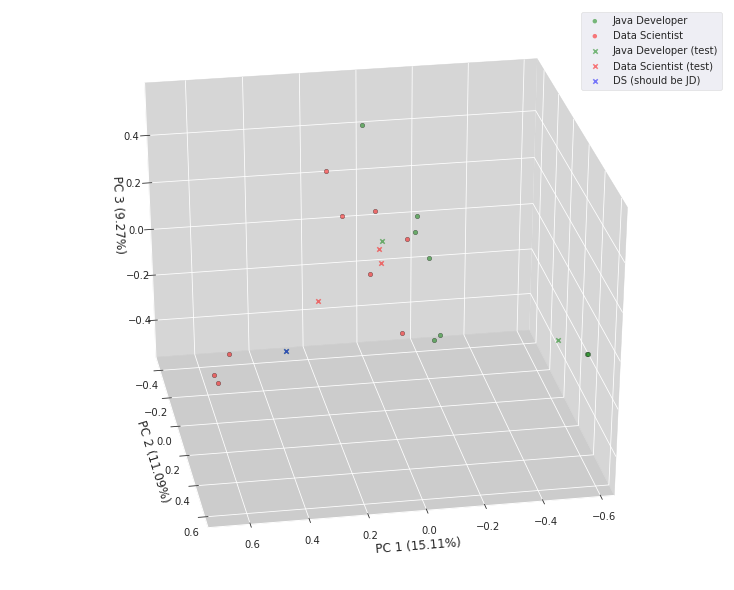

In [28]:
from collections import OrderedDict

# Label list for each data set
labels_train = ['Java Developer' if _ else 'Data Scientist' for _ in y_train]
labels_test = ['Java Developer' if _ else 'Data Scientist' for _ in y_test]

# Label to color dict
label_color_dict = {0: 'red', 1: 'green'}

# Color vector creation
cvec_train = [label_color_dict[label] for label in y_train]
cvec_test = [label_color_dict[label] for label in y_test]

# Create the scatter plot by plotting each point separately
fig = plt.figure(1, figsize = (10, 8))
ax = Axes3D(fig, rect = [0, 0, 1, 1], elev = 30, azim = 80)
for i in range(len(pca_X_train)):
    ax.scatter(pca_X_train[i, 0], pca_X_train[i, 1], pca_X_train[i, 2], \
               c = cvec_train[i], edgecolor = '', alpha = 0.5, label = labels_train[i])
for i in range(len(pca_X_test)):
    ax.scatter(pca_X_test[i, 0], pca_X_test[i, 1], pca_X_test[i, 2], c = cvec_test[i], \
            edgecolor = '', alpha = 0.5, label = labels_test[i] + ' (test)', marker = 'x')

ax.scatter(pca_X_test[4, 0], pca_X_test[4, 1], pca_X_test[4, 2], c = 'blue', \
            edgecolor = '', alpha = 0.5, label = 'DS (should be JD)', marker = 'x')

# Add the axis labels
ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
ax.set_facecolor('white')
ax.w_xaxis.set_pane_color((.8,.8,.8,.8))
ax.w_yaxis.set_pane_color((.8,.8,.8,.8))
ax.w_zaxis.set_pane_color((.8,.8,.8,1))

# Get unique labels for legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
#by_label.move_to_end('Java Developer (test)')
by_label.move_to_end('Data Scientist (test)')
by_label.move_to_end('DS (should be JD)')
ax.legend(by_label.values(), by_label.keys())

plt.show()

Taking into account only the three principal components, we see that the two classes (red and green) are for the most part well separated, both, in the training as well as in the test set (dots and crosses). We have also highlighted in blue the one sample from the test set that got misclassified. It is indeed somewhat of an outlier.

<a id='predict'></a>
### 2.5 Prediction

Lastly, let's make some predictions on new data.

In [29]:
req1 = vectorizer.transform(["""
The ideal candidate should know Python and SQL.
Moreover, he should also have a degree in mathematics.
"""]).toarray()

In [30]:
print(clf_model.predict(req1))

[0]


Correct! This was supposed to be a data scientist.

In [31]:
req2 = vectorizer.transform(["""
The ideal candidate should have studied computer science and be proficient in HTML.
"""]).toarray()

In [32]:
print(clf_model.predict(req2))

[1]


In [33]:
req3 = vectorizer.transform(["""
The ideal candidate should have studied computer science and be proficient in Java.
"""]).toarray()

In [34]:
print(clf_model.predict(req3))

[1]


With both "HTML" and "Java" in the above query, the model correctly predicts a Java Developer.

<a id='conclusion'></a>
## 3. Conclusion

In this experiment, we have taken a job from the SAP careers website and analyzed it for its most important requirements. Different metrics complemented each other to paint a great overall picture what to look for in a candidate. The techniques involved in dissecting job requirements evolved around Natural Language Processing (NLP) for which we used scikit-learn's NLTK library.

We then went on to build a machine model, based on a support vector machine (SVM), which is able to predict the job label given a list of requirements. To accomplish this, we needed to first convert a given block of text into a vector which can be evaluated by the model. This process was facilitated by scikit-learn's TF-IDF (term frequency-inverse document frequency) library which reflects the importance of a word in a document in a collection of documents (the corpus). Our trained model achieved a high accuracy of only one misclassified sample out of six for which we found an explanation. We also tested the model on made-up sentences and achieved wonderful accuracy.

Going forward, we aim to implement the algorithms of this experiment on a webservice with a RESTful API and a permanent SQL database to get queries from web scraping out of memory and make the features accessible to others.